In [1]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

sys.path.append('..')
from util.batcher import Batcher
#from util.stock_loader import Loader

In [2]:
sp1950 = yf.download('^GSPC', start='1950-01-01')
nya1965 = yf.download('^NYA', start='1965-01-01')
nasdaq1965 = yf.download('^IXIC', start='1965-01-01')
wilshire1990 = yf.download('^W5000', start='1990-01-01')

path = '../data'
sp1950.to_csv(f'{path}/sp1950.csv')
nya1965.to_csv(f'{path}/nya1965.csv')
nasdaq1965.to_csv(f'{path}/nasdaq1965.csv')
wilshire1990.to_csv(f'{path}/wilshire1990.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'AMD', 'AMZN', 'ANET', 'APPH', 'AXON',
    'BROS', 'BYND', 'CHWY', 'COIN', 'COUR', 'CRWD', 'DDOG', 'DKNG',
    'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FLGT', 'FUV', 'FVRR', 'GH', 'GMED',
    'GOOG', 'INTG', 'ISRG', 'JD', 'LSPD', 'LULU','MDB', 'MELI', 'MNST',
    'MSFT', 'MTCH', 'NVCR', 'NVDA', 'NYT', 'OKTA', 'OPEN', 'PANW',
    'PINS', 'PTON', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'ROKU', 'SE',
    'SHOP', 'SPLK', 'SQ', 'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO',
    'TWLO', 'TWTR', 'UPST', 'VEEV', 'WK', 'XPEV', 'ZEN', 'ZNGA']
INDICES = ['^GSPC', # S&P 500
           '^IXIC', # Nasdaq
           '^NYA']  # NY Stock Exchange (total)
len(SYMBOLS)

67

In [4]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 5
START = TODAY - timedelta(YEARS_OF_DATA * 365)
START, TODAY

(datetime.date(2017, 4, 16), datetime.date(2022, 4, 15))

In [5]:
batch = SYMBOLS + INDICES

In [6]:
data = (yf.download(batch, start=START, end=TODAY)
        .rename(columns={'Adj Close': 'AdjClose'}))

[*********************100%***********************]  70 of 70 completed


In [7]:
data.tail()

AdjClose                                                   \
                  AAPL        ABMD        ABNB         AMD         AMZN   
Date                                                                      
2022-04-08  170.089996  314.529999  162.559998  101.000000  3089.209961   
2022-04-11  165.750000  299.760010  160.250000   97.370003  3022.439941   
2022-04-12  167.660004  299.640015  160.110001   95.099998  3015.750000   
2022-04-13  170.399994  304.429993  171.850006   97.739998  3110.820068   
2022-04-14  165.289993  306.079987  170.699997   93.059998  3034.129883   

                                                                ...  \
                  ANET  APPH        AXON       BROS       BYND  ...   
Date                                                            ...   
2022-04-08  131.029999  4.41  127.820000  50.570000  43.110001  ...   
2022-04-11  127.160004  4.33  124.400002  52.310001  43.959999  ...   
2022-04-12  127.419998  4.44  125.629997  51.160000  43.580002  ...   
2022-04-13  131.369995  4.59  125.269997  52.119999  45.020000  ...   
2022-04-14  126.570000  4.70  123.220001  53.000000  43.009998  ...   

               Volume                                                    \
                 TWTR        UPST     VEEV      WK        XPEV      ZEN   
Date                                                                      
2022-04-08   83262600   8971700.0   967600  169100   6542600.0  1129800   
2022-04-11  117814000   8731900.0  1087600  305900  10419200.0  1545700   
2022-04-12   60794000  11783100.0   885600  229600   9710800.0  1751000   
2022-04-13   44306700   8371900.0   875600  373700   9296300.0  2071900   
2022-04-14  247211153   9108386.0   488147  221688   5302233.0  1720469   

                                                          
                ZNGA       ^GSPC       ^IXIC        ^NYA  
Date                                                      
2022-04-08  20988800  3453040000  4554890000  3453040000  
2022-04-11  17958000  3452540000  4916860000  3452540000  
2022-04-12  14138300  3451990000  4965220000  3451990000  
2022-04-13  21772400  3273140000  4887660000  3273140000  
2022-04-14  14150792  2316287000  3651448000           0  

[5 rows x 420 columns]

In [8]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock]]
    first_value = sub.AdjClose[stock][sub.AdjClose[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    sub.fillna(method='ffill', inplace=True)
    return sub

In [9]:
def get_daily_returns(x):
    n = len(x)
    x = np.array(x)
    return x[2:n] / x[1:(n - 1)] - 1 

In [10]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [11]:
def rescale(a):
    a = a - a.min()
    a = a / a.max()
    return a

In [12]:
def vals_to_quantiles(a):
    n = len(a)
    qs = np.linspace(0, 1, n)
    order = np.argsort(a)
    out = qs[order]
    return out

In [13]:
# Test
a = np.array([1, 9, 8, 5])
#vals_to_quantiles(a)
rescale(a)

array([0.   , 1.   , 0.875, 0.5  ])

In [14]:
def get_rsi(stock_data, window=14):
    df = stock_data.copy()
    df['deltas'] = df.AdjClose.diff(1)
    df['gains'] = df.deltas.clip(lower=0)
    df['losses'] = df.deltas.clip(upper=0).abs()
    df['avg_gain'] = (df.gains
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    df['avg_loss'] = (df.losses
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    
    # avg gains
    pd.options.mode.chained_assignment = None
    for i, row in enumerate(df.avg_gain.iloc[window + 1:]):
        df.avg_gain.iloc[i + window + 1] = (
            (df.avg_gain.iloc[i + window] * (window - 1) 
             + df.gains.iloc[i + window + 1]) 
            / window)
    # avg losses
    for i, row in enumerate(df.avg_loss.iloc[window + 1:]):
        df.avg_loss.iloc[i + window + 1] = (
            (df.avg_loss.iloc[i + window] * (window - 1)
             + df.losses.iloc[i + window + 1])
            / window)
    df['rs'] = df.avg_gain / df.avg_loss
    df['rsi'] = 100 - (100 / (1. + df.rs))
    return df.rsi

In [15]:
# Test
stock = 'DKNG'
stock_data = get_stock_data(stock, data)
rsiq = get_rsi(stock_data)

In [16]:
def get_macd(stock_data, fast=60, slow=90, signal=80, plot=False):
    df = stock_data.copy()
    exp1 = df.AdjClose.ewm(span=fast, adjust=False).mean()
    exp2 = df.AdjClose.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    exp3 = macd.ewm(span=signal, adjust=False).mean()
    histo = macd - exp3
    hdiff = histo.diff(1)
    is_rising = 1 * (hdiff > 0)
    if plot:
        plt.plot(macd, label='MACD', color='red')
        plt.plot(exp3, label='Signal', color='green')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.legend();
        plt.figure()
        plt.plot(histo, color='blue')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.axhline(y=0, color='k')
        plt.figure()
        plt.plot(is_rising)
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
    return is_rising

In [17]:
LMB = 0.9
RSI_WINDOW = 14
MACD_PARAMS = (60, 90, 80, False)

In [18]:
def process_stock(stock, data, lmb=LMB, plot=False):
    stock_data = get_stock_data(stock, data)
    n = len(stock_data.AdjClose[~np.isnan(stock_data.AdjClose)])
    stock_data['direction'] = get_macd(stock_data, *MACD_PARAMS)
    stock_data['rsi'] = get_rsi(stock_data, window=RSI_WINDOW)
    stock_data.rsi = stock_data.rsi.rank(pct=True)
    sharpe = get_sharpe(get_daily_returns(stock_data.AdjClose))
    stock_data.fillna(method='ffill', inplace=True)
    stock_data.fillna(method='bfill', inplace=True)
    WINDOW = min(n // 2, 125)
    stock_data['ann_high'] = (stock_data.AdjClose
                              .rolling(window=WINDOW)
                              .max())
    stock_data['ann_low'] = (stock_data.AdjClose
                             .rolling(window=WINDOW)
                             .min())
    stock_data['drawdown'] = stock_data.AdjClose / stock_data.ann_high
    stock_data.drawdown = stock_data.drawdown.rank(pct=True)
    stock_data['pullup'] = stock_data.AdjClose / stock_data.ann_low
    #return stock_data.pullup
    stock_data.pullup = stock_data.pullup.rank(pct=True)
    w = [lmb ** t for t in range(n)][::-1]
    stock_data['W'] = w
    stock_data['n_samp'] = (stock_data.Volume / 100)  * stock_data.W
    stock_data['value'] = ((stock_data.Close 
                            + stock_data.High 
                            + stock_data.Low 
                            + stock_data.Open) 
                           / 4)
    stock_data['est'] = np.nan
    for day in stock_data.index:
        sub = stock_data[stock_data.index <= day]
        weights = sub.n_samp
        weights = weights / weights.sum()
        values = sub.value
        est = np.dot(weights, values)
        stock_data.loc[day, 'est'] = est
    stock_data['resid'] = stock_data.AdjClose / stock_data.est
    stock_data.resid = stock_data.resid.rank(pct=True)
    stock_data.sort_values('resid', inplace=True)
    stock_data['dev'] = np.array(range(n)) / n
    stock_data.dev = stock_data.dev.rank(pct=True)
    stock_data.sort_index(inplace=True)
    if plot:
        plt.figure(figsize=(12, 8))
        plt.plot(stock_data.Close, label='Close')
        plt.plot(stock_data.est, label='Est')
        plt.yscale('log')
        plt.plot(stock_data.ann_high, color='green')
        plt.plot(stock_data.ann_low, color='red')
        plt.legend();
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.dev)
        plt.axhline(0.5, color='k')
        plt.title(stock)
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.drawdown, color='red', label='drawdown')
        plt.plot(stock_data.pullup, color='green', label='pullup')
        plt.plot(np.sqrt(stock_data.drawdown * stock_data.pullup),
                 color='grey',
                 label='geomean')
        plt.yscale('log')
        plt.legend()
    return (stock_data.direction.tolist()[-1],
            stock_data.rsi.tolist()[-1],
            stock_data.resid.tolist()[-1], 
            stock_data.dev.tolist()[-1],
            stock_data.drawdown.tolist()[-1],
            stock_data.pullup.tolist()[-1],
            sharpe)

(0,
 0.15569823434991975,
 0.11507936507936507,
 0.11507936507936507,
 0.1382042253521127,
 0.12852112676056338,
 0.7360965801754367)

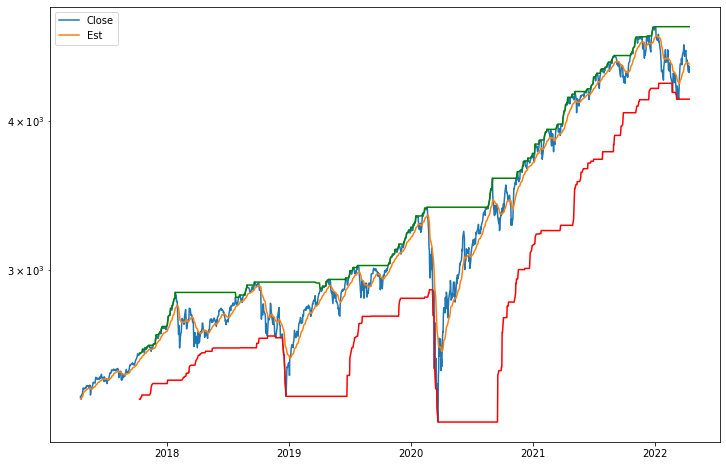

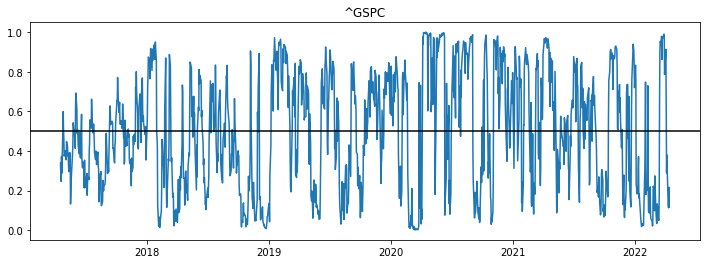

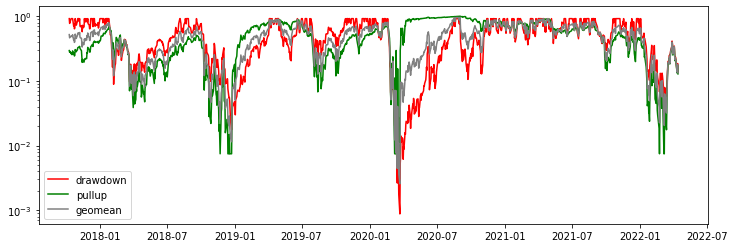

In [19]:
process_stock('^GSPC', data.copy(), plot=True)

In [20]:
out = []
for stock in batch:
    print(f'{stock}...', end=' ')
    direction, rsi, mult, dev, drop, climb, sharpe = process_stock(
        stock, data)
    out.append([stock, direction, rsi, mult, dev, drop, climb, sharpe])

AAPL... ABMD... ABNB... AMD... AMZN... ANET... APPH... AXON... BROS... BYND... CHWY... COIN... COUR... CRWD... DDOG... DKNG... DOCU... DUOL... EDIT... ETSY... FLGT... FUV... FVRR... GH... GMED... GOOG... INTG... ISRG... JD... LSPD... LULU... MDB... MELI... MNST... MSFT... MTCH... NVCR... NVDA... NYT... OKTA... OPEN... PANW... PINS... PTON... QDEL... RBLX... RDFN... RGEN... ROKU... SE... SHOP... SPLK... SQ... TASK... TDOC... TEAM... TREX... TTD... TTWO... TWLO... TWTR... UPST... VEEV... WK... XPEV... ZEN... ZNGA... ^GSPC... ^IXIC... ^NYA... 

In [21]:
out = pd.DataFrame(
    data=out, 
    columns=['stock', 'direction', 'RSI', 'fair_value_mult', 
             'dev_quantile', 'drop','climb', 'sharpe'])
out['geomean'] = np.sqrt(out['drop'] * out.climb)
out['score'] = (out.fair_value_mult
                * out.dev_quantile
                * out['drop']
                * out.climb) ** (1/4) 
out['RSIRev'] = 1 - out.RSI
out = out[['stock', 'direction', 'RSI', 'RSIRev', 'fair_value_mult', 
           'dev_quantile', 'drop', 'climb','geomean', 'score', 
           'sharpe']]
out.RSI.fillna(out.RSI.median())
out.RSIRev.fillna(out.RSIRev.median())

out.sort_values('stock')

,stock,direction,RSI,RSIRev,fair_value_mult,dev_quantile,drop,climb,geomean,score,sharpe
0,AAPL,0,0.187801,0.812199,0.333333,0.333333,0.302817,0.134683,0.201951,0.259455,1.188220
1,ABMD,0,0.323435,0.676565,0.260317,0.260317,0.397007,0.251761,0.316150,0.286879,0.653839
2,ABNB,1,0.673846,0.326154,0.728614,0.728614,0.637209,0.772093,0.701416,0.714886,0.548504
3,AMD,0,0.032905,0.967095,0.015873,0.015873,0.013204,0.006162,0.009020,0.011966,0.982334
4,AMZN,0,0.177368,0.822632,0.089683,0.089683,0.092430,0.321303,0.172331,0.124318,0.931557
...,...,...,...,...,...,...,...,...,...,...,...
65,ZEN,1,0.692616,0.307384,0.627778,0.627778,0.519366,0.507042,0.513167,0.567587,0.913639
66,ZNGA,0,0.187801,0.812199,0.292857,0.292857,0.715669,0.840669,0.775655,0.476609,0.772274
67,^GSPC,0,0.155698,0.844302,0.115079,0.115079,0.138204,0.128521,0.133275,0.123843,0.736097
68,^IXIC,0,0.126003,0.873997,0.065873,0.065873,0.038732,0.093310,0.060118,0.062929,0.838325


In [22]:
out.geomean.quantile([0.05, 0.99])

0.05    0.008949
0.99    0.820972
Name: geomean, dtype: float64

In [23]:
out.to_csv('individ_quantiles.csv', index=False)

In [24]:
!open individ_quantiles.csv